In [2]:
import pandas as pd
import seaborn as sns
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
headers = {'flips_and_switches':['sample_id','num_switches','num_flips','num_correct','switch_error_rate','flip_error_rate','accurately_phased_rate'],
           'switch_errors':['sample_id', 'n_switch_errors',  'num_checked', 'switch_error_rate'],
           'frequency':['minor_allele_count', 'n_switch_errors', 'n_checked', 'switch_error_rate'],
           'type': ['ref_or_alt_allele', 'n_switch_errors', 'n_checked', 'switch_error_rate'],
           'variant_switch': ['variant_id', 'position', 'n_switch_errors', 'n_checked', 'switch_error_rate'],
           'block_length':['sample','switch_error_site']}
stat_prefixes={'flips_and_switches':'flipsAndSwitches',
               'switch_errors':'sample.switch',
               'frequency':'frequency',
               'type':'type',
               'variant_switch':'variant.switch',
               'block_length':'block.switch'}
analysis_suffixes = {'common_variants':{'HPRC_samples':{'phased_with_reference_panel':'common_pangenome_panelphased_vs_pangenome'},
                                        'trios': {'phased_without_parents_or_pedigree':'common_noparents_vs_trios'}},
                     'rare_variants':  {'HPRC_samples':{'phased_with_reference_panel':'rare_pangenome_panelphased_vs_pangenome',
                                                        'phased_without_parents_or_pedigree':'noparents_vs_HPRC',
                                                        'phased_with_parents_and_pedigree':'phased_vs_HPRC'},
                                        'trios': {'phased_without_parents_or_pedigree':'rare_noparents_vs_trios',
                                                        'phased_with_parents_and_pedigree': 'panel_vs_trios'}}}

In [4]:
phasing_stats_datasets = dict()
phasing_stats_folder='phasing_stats/'

for statistic, header in headers.items():
    print (statistic)
    if os.path.exists(f'{phasing_stats_folder}/{statistic}.parquet'):
        print ('loading from presaved parquet')
        phasing_stats_datasets[statistic] = pd.read_parquet(f'{phasing_stats_folder}/{statistic}.parquet')
    else:
        phasing_stats_datasets[statistic] = list()
        for variant_category in analysis_suffixes.keys():
            for verification_sample in analysis_suffixes[variant_category].keys():
                for phasing_method, prefix in analysis_suffixes[variant_category][verification_sample].items():
                        for i in list(range(1,23)) + ['X']:
                            file = glob.glob(phasing_stats_folder + f'{prefix}_chr{i}.*{stat_prefixes[statistic]}*')
                            if len(file) == 1:
                                contig_file = pd.read_csv(file[0], sep=' ', names=header)
                                contig_file['chrom'] = f'chr{i}'
                                contig_file['stat'] = statistic
                                contig_file['method_of_phasing'] = phasing_method
                                contig_file['ground_truth_data_source'] = verification_sample
                                contig_file['variants'] = variant_category
                                phasing_stats_datasets[statistic].append(contig_file)
                            else:
                                print (phasing_stats_folder + f'{prefix}_chr{i}.*{stat_prefixes[statistic]}*')
        if len(phasing_stats_datasets[statistic]) > 1:
            phasing_stats_datasets[statistic] = pd.concat(phasing_stats_datasets[statistic]).reset_index(drop=True)
            phasing_stats_datasets[statistic].to_parquet(f'{phasing_stats_folder}/{statistic}.parquet', index=False)


flips_and_switches
switch_errors
frequency
type
variant_switch
block_length


In [5]:
def post_process_switch_and_flips(df):
    HPRC_all_contig_switch_errors = df.groupby(['sample_id','method_of_phasing','ground_truth_data_source','variants']).sum(numeric_only=True)
    HPRC_all_contig_switch_errors['total_sites'] = HPRC_all_contig_switch_errors.sum(1)
    HPRC_all_contig_switch_errors['switch_error_rate'] = HPRC_all_contig_switch_errors.num_switches/HPRC_all_contig_switch_errors.total_sites*100
    HPRC_all_contig_switch_errors['flip_error_rate'] = HPRC_all_contig_switch_errors.num_flips/HPRC_all_contig_switch_errors.total_sites*100
    HPRC_all_contig_switch_errors['accurately_phased_rate'] = HPRC_all_contig_switch_errors.num_correct/HPRC_all_contig_switch_errors.total_sites*100
    HPRC_all_contig_switch_errors = HPRC_all_contig_switch_errors.loc[HPRC_all_contig_switch_errors.total_sites>0]
    return HPRC_all_contig_switch_errors

def summarize_switch_errors(df):
    pass

def summarize_frequency(df):
    pass

def summarize_type(df):
    pass

def summarize_variant_switch(df):
    pass

def summarize_block_length(df):
    return df

def calc_block_lengths(df):
    return df.groupby(['chrom','sample']).apply(lambda x: x.switch_error_site.diff()).reset_index().switch_error_site

                                    count      mean       std       min  \
method_of_phasing                                                         
phased_with_parents_and_pedigree     39.0  0.090337  0.060377  0.037190   
phased_with_reference_panel          39.0  1.165489  0.342749  0.716768   
phased_without_parents_or_pedigree   39.0  1.024235  0.401280  0.543919   

                                         25%       50%       75%       max  
method_of_phasing                                                           
phased_with_parents_and_pedigree    0.049504  0.068061  0.096409  0.231472  
phased_with_reference_panel         0.902415  1.049706  1.245421  1.876453  
phased_without_parents_or_pedigree  0.720734  0.801954  1.161853  1.936100  
method_of_phasing
phased_with_parents_and_pedigree      0.018949
phased_with_reference_panel           0.107572
phased_without_parents_or_pedigree    0.125942
Name: switch_error_rate, dtype: float64


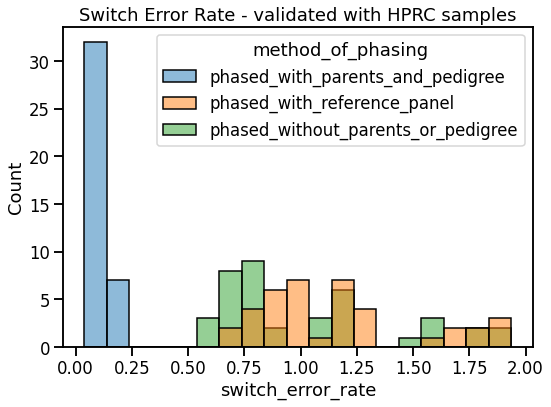

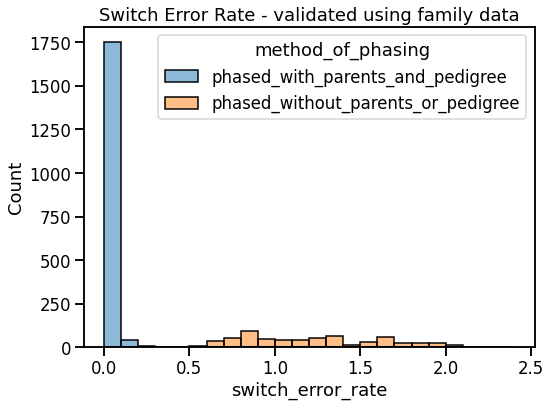

In [10]:
switch_errors = post_process_switch_and_flips(phasing_stats_datasets['flips_and_switches']).reset_index()

plot_HPRC = switch_errors.loc[(switch_errors.ground_truth_data_source=='HPRC_samples') & (switch_errors.variants=='rare_variants')]
plot_trios = switch_errors.loc[(switch_errors.ground_truth_data_source=='trios') & (switch_errors.variants=='rare_variants')]

sns.set_context('talk')
plt.figure(figsize=(8,6))
ax = sns.histplot(x='switch_error_rate', binwidth=.1, hue='method_of_phasing', data=plot_HPRC)
ax.set_title('Switch Error Rate - validated with HPRC samples')
plt.tight_layout()
plt.savefig('phasing_stats/SER_HPRC.png', facecolor='white')

plt.figure(figsize=(8,6))
ax = sns.histplot(x='switch_error_rate', binwidth=.1, hue='method_of_phasing', data=plot_trios)
ax.set_title('Switch Error Rate - validated using family data')
plt.tight_layout()
plt.savefig('phasing_stats/SER_trios.png', facecolor='white')

print(plot_HPRC.groupby('method_of_phasing').switch_error_rate.describe())

print(plot_HPRC.groupby('method_of_phasing').switch_error_rate.sem()*1.96)

/home/lalli/.linuxbrew/Cellar/python@3.10/3.10.8/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 92.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


                                    count      mean       std       min  \
method_of_phasing                                                         
phased_with_parents_and_pedigree     39.0  0.090337  0.060377  0.037190   
phased_with_reference_panel          39.0  1.165489  0.342749  0.716768   
phased_without_parents_or_pedigree   39.0  1.024235  0.401280  0.543919   

                                         25%       50%       75%       max  
method_of_phasing                                                           
phased_with_parents_and_pedigree    0.049504  0.068061  0.096409  0.231472  
phased_with_reference_panel         0.902415  1.049706  1.245421  1.876453  
phased_without_parents_or_pedigree  0.720734  0.801954  1.161853  1.936100  
method_of_phasing
phased_with_parents_and_pedigree      0.018949
phased_with_reference_panel           0.107572
phased_without_parents_or_pedigree    0.125942
Name: switch_error_rate, dtype: float64


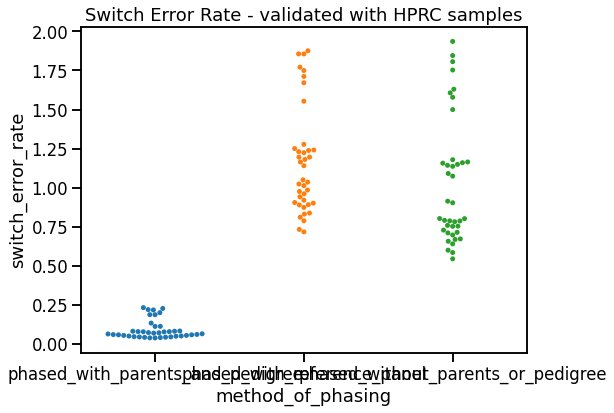

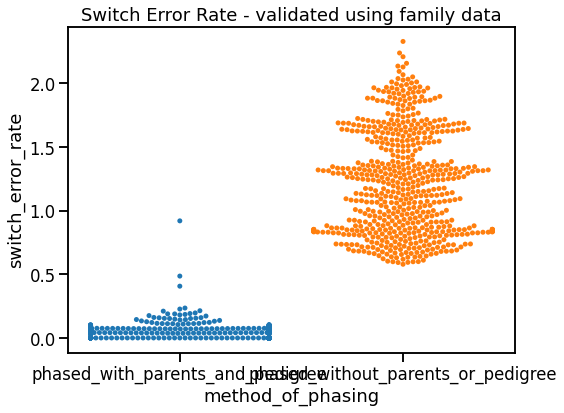

In [7]:
plt.figure(figsize=(8,6))
ax = sns.swarmplot(y='switch_error_rate', x='method_of_phasing', data=plot_HPRC)
ax.set_title('Switch Error Rate - validated with HPRC samples')
plt.figure(figsize=(8,6))
ax = sns.swarmplot(y='switch_error_rate', x='method_of_phasing', data=plot_trios)
ax.set_title('Switch Error Rate - validated using family data')

print(plot_HPRC.groupby('method_of_phasing').switch_error_rate.describe())

print(plot_HPRC.groupby('method_of_phasing').switch_error_rate.sem()*1.96)

0.0

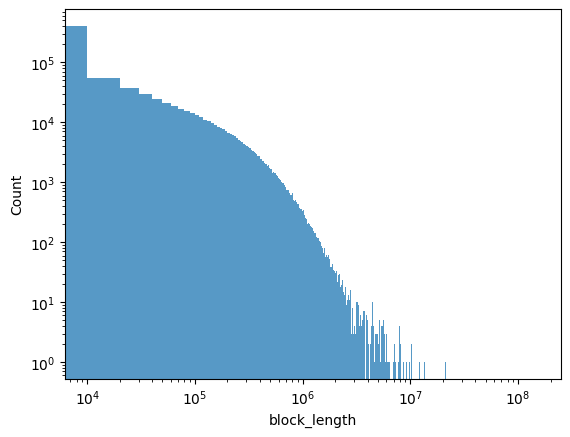

In [121]:
# ax = sns.histplot(df.block_length, binwidth=10000)
# ax.set_yscale('log')
# ax.set_xscale('log')
# df.block_length.min()

In [148]:
def plot_phasing_blocks(sample, df, cytobands='chm13v2.0_cytobands_allchrs.bed'):
    """Plot phasing blocks from one sample"""
    from ideograms import plot_ideogram

    data = df.loc[df['sample']==sample, ['chrom', 'switch_error_site']].rename(columns={'switch_error_site':'start'}).reset_index(drop=True)
    # data = data.groupby('chrom').apply(lambda x: x.shift(1)).fillna(0)
    data['end'] = data.groupby('chrom')['start'].shift(-1)
    data = data.dropna()
    data.end = data.end.astype(int)
    data['name'] = data.index.astype(int)
    print(data)
    ax = plot_ideogram('chm13v2.0_cytobands_allchrs.bed', data, figsize=(8,12), data_height=1.2, inclusive=True)
    return ax

      chrom   start        end   name
0      chr1  139203     514232      0
1      chr1  514232     518535      1
2      chr1  518535     598723      2
3      chr1  598723     600001      3
4      chr1  600001     748864      4
...     ...     ...        ...    ...
25677  chrX  920535     921456  25677
25678  chrX  921456     946219  25678
25679  chrX  946219     979711  25679
25680  chrX  979711     981357  25680
25681  chrX  981357  154237271  25681

[25660 rows x 4 columns]
adding ideograms...
adding genes...


<AxesSubplot:>

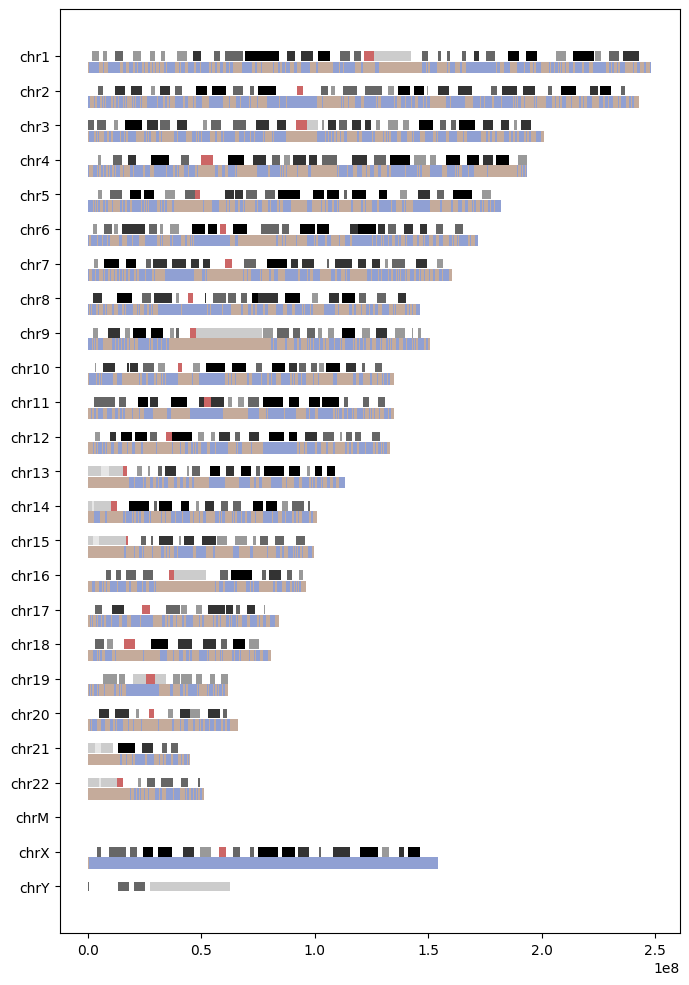

In [149]:
from ideograms import plot_ideogram
plot_phasing_blocks('HG00621', df)

In [129]:

# data_list=list()
# empty_line=pd.DataFrame(['chr1', -1, -1, -1])
# for chrom, df in data.groupby('chrom'):
#     chrom_end = data.loc[data.chrom==chrom, 'end'].max()
#     if df.iat[0, 1] != 0:
#         df = pd.concat((empty_line, df))
#         df.iat[0, 1] = 0
#         df.iat[0, 2] = df.iat[1, 1]
#     if df.iat[0, 2] != chrom_end:
#         df = pd.concat((df, empty_line))
#         df.iat[-1, 1] = df.iat[-2, 2]
#         df.iat[-1, 2] = chrom_end
#     data_list.append(df)